In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
import optuna
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, mutual_info_classif, mutual_info_regression
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import logging
from tensorflow import keras
import warnings

In [69]:
warnings.filterwarnings('ignore')

In [70]:
N_SAMPLES = 100

In [71]:
class_df = pd.read_csv('../data/csgo_processed.csv', sep=';')
class_y = class_df['bomb_planted'].values[:N_SAMPLES]
class_X = class_df.drop(['bomb_planted'], axis=1).values[:N_SAMPLES]
oversampler = SMOTE(random_state=0)
class_X, class_y = oversampler.fit_resample(class_X, class_y)
ss = StandardScaler()
class_X = ss.fit_transform(class_X)

In [72]:
reg_df = pd.read_csv('../data/diamonds_processed.csv', sep=';')
reg_y = reg_df['price'].values[:N_SAMPLES]
reg_X = reg_df.drop(['price'], axis=1).values[:N_SAMPLES]
ss = StandardScaler()
reg_X = ss.fit_transform(reg_X)

In [73]:
k_best_cls = SelectKBest(score_func=f_classif, k=2)
k_best_reg = SelectKBest(score_func=f_regression, k=9)
class_X = k_best_cls.fit_transform(class_X, class_y)
reg_X = k_best_reg.fit_transform(reg_X, reg_y)

In [74]:
categorical_y = tf.keras.utils.to_categorical(class_y)

In [75]:
class_X_train, class_X_test, class_y_train, class_y_test = train_test_split(class_X, categorical_y, test_size=0.2, random_state=0)
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(reg_X, reg_y, test_size=0.2, random_state=0)

In [76]:
mlp_rand_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000]
}

space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'solver': hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
    'alpha': hp.loguniform('alpha', -4, -2),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.choice('max_iter', [200, 500, 1000]),
    'early_stopping': hp.choice('early_stopping', [True, False]),
    'n_iter_no_change': 10
}

In [77]:
class_mlp = MLPClassifier()

kf = KFold(n_splits=10)

random_search = RandomizedSearchCV(class_mlp, param_distributions=mlp_rand_param_dist, n_iter=10, cv=kf, n_jobs=-1)

random_search.fit(class_X_train, class_y_train)
print("MLPClassifier:")
print("Best score found: ", random_search.best_score_)
print("Best parameters found: ", random_search.best_params_)
class_mlp = random_search.best_estimator_

MLPClassifier:
Best score found:  0.9928571428571429
Best parameters found:  {'solver': 'adam', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'alpha': 0.1, 'activation': 'tanh'}


In [78]:
reg_mlp = MLPRegressor()

kf = KFold(n_splits=10)

random_search = RandomizedSearchCV(reg_mlp, param_distributions=mlp_rand_param_dist, n_iter=10, cv=kf, n_jobs=-1)

random_search.fit(reg_X_train, reg_y_train)
print("MLPRegressor:")
print("Best score found: ", random_search.best_score_)
print("Best parameters found: ", random_search.best_params_)
reg_mlp = random_search.best_estimator_

MLPRegressor:
Best score found:  0.8170620828703772
Best parameters found:  {'solver': 'sgd', 'max_iter': 1000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50,), 'alpha': 0.1, 'activation': 'relu'}


In [79]:
def objective(trial):
    params = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001, 0.01, 0.1]),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_categorical('max_iter', [100, 200, 500, 1000])
    }
    
    mlp = MLPClassifier(**params)
    score = cross_val_score(mlp, class_X_train, class_y_train, cv=10, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Optuna:")
print("Best score found: ", study.best_value)
print("Best parameters found: ", study.best_params)
# class_mlp = MLPClassifier(**study.best_params)
# class_mlp.fit(class_X_train, class_y_train)

[I 2025-05-30 04:34:43,804] A new study created in memory with name: no-name-af737949-b544-42f7-aa18-b7b362df9ce3
[I 2025-05-30 04:34:43,940] Trial 0 finished with value: 0.2719047619047619 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.01, 'learning_rate': 'adaptive', 'max_iter': 100}. Best is trial 0 with value: 0.2719047619047619.
[I 2025-05-30 04:34:44,046] Trial 1 finished with value: 0.971904761904762 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'invscaling', 'max_iter': 200}. Best is trial 1 with value: 0.971904761904762.
[I 2025-05-30 04:34:44,123] Trial 2 finished with value: 0.9928571428571429 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200}. Best is trial 2 with value: 0.9928571428571429.
[I 2025-05-30 04:34:44,356] Trial 3 finished with value: 

Optuna:
Best score found:  0.9928571428571429
Best parameters found:  {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.01, 'learning_rate': 'invscaling', 'max_iter': 200}


In [80]:
# def objective(trial):
#     params = {
#         'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
#         'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001, 0.01, 0.1]),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
#         'max_iter': trial.suggest_categorical('max_iter', [200, 500, 1000]),
#         'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
#         'n_iter_no_change': 10
#     }
    
#     mlp = MLPRegressor(**params)
#     score = cross_val_score(mlp, reg_X_train, reg_y_train, cv=10, n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print("Optuna:")
# print("Best score found: ", study.best_value)
# print("Best parameters found: ", study.best_params)
# # reg_mlp = MLPRegressor(**study.best_params)
# # reg_mlp.fit(reg_X_train, reg_y_train)

In [81]:
def objective(params):
    mlp = MLPClassifier(**params)
    score = cross_val_score(mlp, class_X_train, class_y_train, cv=10, n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()

best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
print("Hyperopt:")
print("Best score found: ", -trials.best_trial['result']['loss'])
print("Best parameters found: ", best_params)
# best_mlp = MLPClassifier(**best_params)
# best_mlp.fit(class_X_train, class_y_train)

100%|██████████| 100/100 [00:16<00:00,  5.91trial/s, best loss: -0.9928571428571429]
Hyperopt:
Best score found:  0.9928571428571429
Best parameters found:  {'activation': np.int64(0), 'alpha': np.float64(0.0957287355011419), 'early_stopping': np.int64(1), 'hidden_layer_sizes': np.int64(3), 'learning_rate': np.int64(2), 'max_iter': np.int64(1), 'solver': np.int64(2)}


In [82]:
# def objective(params):
#     mlp = MLPRegressor(**params)
#     score = cross_val_score(mlp, reg_X_train, reg_y_train, cv=10, n_jobs=-1).mean()
#     return {'loss': -score, 'status': STATUS_OK}

# trials = Trials()

# best_params = fmin(objective, reg_space, algo=tpe.suggest, max_evals=100, trials=trials)
# print("Hyperopt:")
# print("Best score found: ", -trials.best_trial['result']['loss'])
# print("Best parameters found: ", best_params)
# # reg_mlp = MLPRegressor(**best_params)
# # reg_mlp.fit(reg_X_train, reg_y_train)

In [83]:
def objective(trial):
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    val_accuracies = []
    
    for train_idx, val_idx in kfold.split(class_X_train):
        X_train_fold, X_val_fold = class_X_train[train_idx], class_X_train[val_idx]
        y_train_fold, y_val_fold = class_y_train[train_idx], class_y_train[val_idx]
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=10,
            verbose=0
        )
        val_accuracies.append(history.history['val_accuracy'][-1])
        
        model.set_weights(model.get_weights())
        
    return np.mean(val_accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
class_optuna_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    'sgd': keras.optimizers.SGD(learning_rate=best_params['learning_rate']),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
}

class_optuna_model.compile(
    optimizer=optimizers[best_params['optimizer']],
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

class_optuna_model.fit(
    class_X_train, class_y_train,
    epochs=10,
    verbose=0
)

loss, accuracy = class_optuna_model.evaluate(class_X_test, class_y_test)
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Тестовая точность: {accuracy:.4f}")
class_nn = class_optuna_model

[I 2025-05-30 04:35:17,815] A new study created in memory with name: no-name-d2fc9dac-62a5-42ac-b3f5-85933d6645ea
[I 2025-05-30 04:35:24,519] Trial 0 finished with value: 0.9519047558307647 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.000227207820481113}. Best is trial 0 with value: 0.9519047558307647.
[I 2025-05-30 04:35:31,048] Trial 1 finished with value: 0.9090476095676422 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0009745871849624824}. Best is trial 0 with value: 0.9519047558307647.
[I 2025-05-30 04:35:37,540] Trial 2 finished with value: 0.88857142329216 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0011899244308276912}. Best is trial 0 with value: 0.9519047558307647.
[I 2025-05-30 04:35:44,029] Trial 3 finished with value: 0.5638095319271088 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0003986444509314537}. Best is trial 0 with value: 0.9519047558307647.
[I 2025-05-30 04:35:50,761] Trial 4 finished with value: 0.992857140302658 an

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9815 - loss: 0.0966
Лучшие гиперпараметры: {'optimizer': 'adam', 'learning_rate': 0.0015326017758714155}
Тестовая точность: 0.9722


In [84]:
def build_class_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(class_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_class_model,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner',
    project_name='class_model'
)

tuner.search(
    class_X_train, class_y_train,
    epochs=10,
    validation_data=(class_X_test, class_y_test),
    verbose=1
)

class_kt_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Лучшие гиперпараметры:")
print(f"Оптимизатор: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

loss, accuracy = class_kt_model.evaluate(class_X_test, class_y_test)
print(f"\nТестовая точность: {accuracy:.4f}")

Reloading Tuner from keras_tuner\class_model\tuner0.json
Лучшие гиперпараметры:
Оптимизатор: rmsprop
Learning Rate: 0.01
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0133 

Тестовая точность: 1.0000


In [85]:
def objective(trial):
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mse',
        metrics=['mae']
    )
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    val_losses = []
    
    for train_idx, val_idx in kfold.split(reg_X_train):
        X_train_fold, X_val_fold = reg_X_train[train_idx], reg_X_train[val_idx]
        y_train_fold, y_val_fold = reg_y_train[train_idx], reg_y_train[val_idx]
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=10,
            verbose=0
        )
        val_losses.append(history.history['val_loss'][-1])
        
    return np.mean(val_losses)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
reg_optuna_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

optimizers = {
    'adam': keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    'sgd': keras.optimizers.SGD(learning_rate=best_params['learning_rate']),
    'rmsprop': keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
}

reg_optuna_model.compile(
    optimizer=optimizers[best_params['optimizer']],
    loss='mse',
    metrics=['mae']
)

reg_optuna_model.fit(
    reg_X_train, reg_y_train,
    epochs=10,
    verbose=0
)

loss, mae = reg_optuna_model.evaluate(reg_X_test, reg_y_test)
print(f"Лучшие гиперпараметры: {best_params}")
print(f"Тестовая MSE: {loss:.4f}, MAE: {mae:.4f}")

[I 2025-05-30 04:36:25,772] A new study created in memory with name: no-name-bae680bd-8e7e-4b02-9fba-21f03550a22e
[I 2025-05-30 04:36:32,460] Trial 0 finished with value: 2710461.275 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00032048045387353256}. Best is trial 0 with value: 2710461.275.
[I 2025-05-30 04:36:39,257] Trial 1 finished with value: 2711135.921875 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00014968070051578044}. Best is trial 0 with value: 2710461.275.
[I 2025-05-30 04:36:45,784] Trial 2 finished with value: 1.9382491828304479e+18 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.00036145335639211376}. Best is trial 0 with value: 2710461.275.
[W 2025-05-30 04:36:52,337] Trial 3 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.002612006772072013} because of the following error: The value nan is not acceptable.
[W 2025-05-30 04:36:52,337] Trial 3 failed with value np.float64(nan).
[W 2025-05-30 04:36:58,882] Trial 4 failed w

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2772155.2500 - mae: 1235.0957
Лучшие гиперпараметры: {'optimizer': 'adam', 'learning_rate': 0.0024263858202508842}
Тестовая MSE: 2772155.2500, MAE: 1235.0957


In [ ]:
def build_reg_model(hp):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(reg_X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    optimizers = {
        'adam': keras.optimizers.Adam(learning_rate=lr),
        'sgd': keras.optimizers.SGD(learning_rate=lr),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=lr)
    }
    
    model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_reg_model,
    objective='val_loss',
    max_trials=10,
    directory='keras_tuner',
    project_name='reg_model'
)

tuner.search(
    reg_X_train, reg_y_train,
    epochs=10,
    validation_data=(reg_X_test, reg_y_test),
    verbose=1
)

reg_kt_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Лучшие гиперпараметры:")
print(f"Оптимизатор: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

test_loss, test_mae = reg_kt_model.evaluate(reg_X_test, reg_y_test)
print(f"\nТестовая MSE: {test_loss:.4f}, MAE: {test_mae:.4f}")
reg_nn = reg_kt_model

Reloading Tuner from keras_tuner\reg_model\tuner0.json

Лучшие гиперпараметры:
Оптимизатор: rmsprop
Learning Rate: 0.01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 908303.8125 - mae: 755.4518

Тестовая MSE: 908303.8125, MAE: 755.4518


In [ ]:
class_mlp

MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(100, 100),
              learning_rate='invscaling')


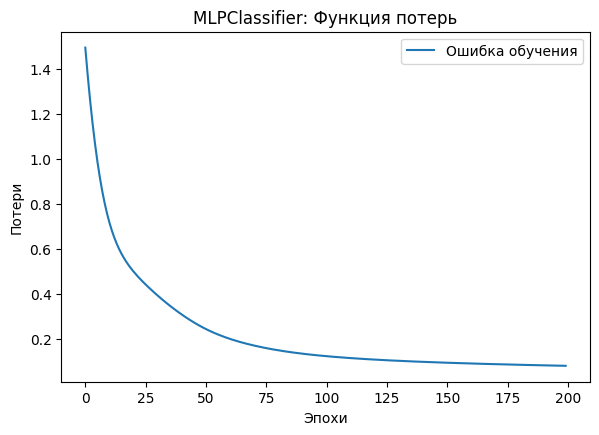

In [ ]:
train_acc = accuracy_score(class_y_train, class_mlp.predict(class_X_train))
test_acc = accuracy_score(class_y_test, class_mlp.predict(class_X_test))
plt.figure(figsize=(15, 10))
plt.plot(class_mlp.loss_curve_, label='Ошибка обучения')
plt.title('MLPClassifier: Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

In [88]:
reg_mlp

MLPRegressor(alpha=0.1, hidden_layer_sizes=(50,), learning_rate='invscaling',
             max_iter=1000, solver='sgd')

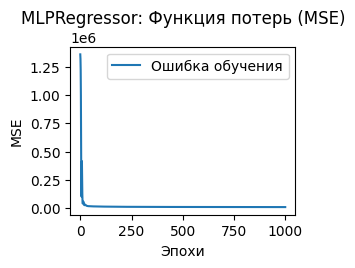

In [ ]:
train_mse = mean_squared_error(reg_y_train, reg_mlp.predict(reg_X_train))
test_mse = mean_squared_error(reg_y_test, reg_mlp.predict(reg_X_test))
plt.figure(figsize=(15, 10))
plt.plot(reg_mlp.loss_curve_, label='Ошибка обучения')
plt.title('MLPRegressor: Функция потерь (MSE)')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.legend()

In [89]:
class_nn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 2,338 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,678 (18.28 KB)

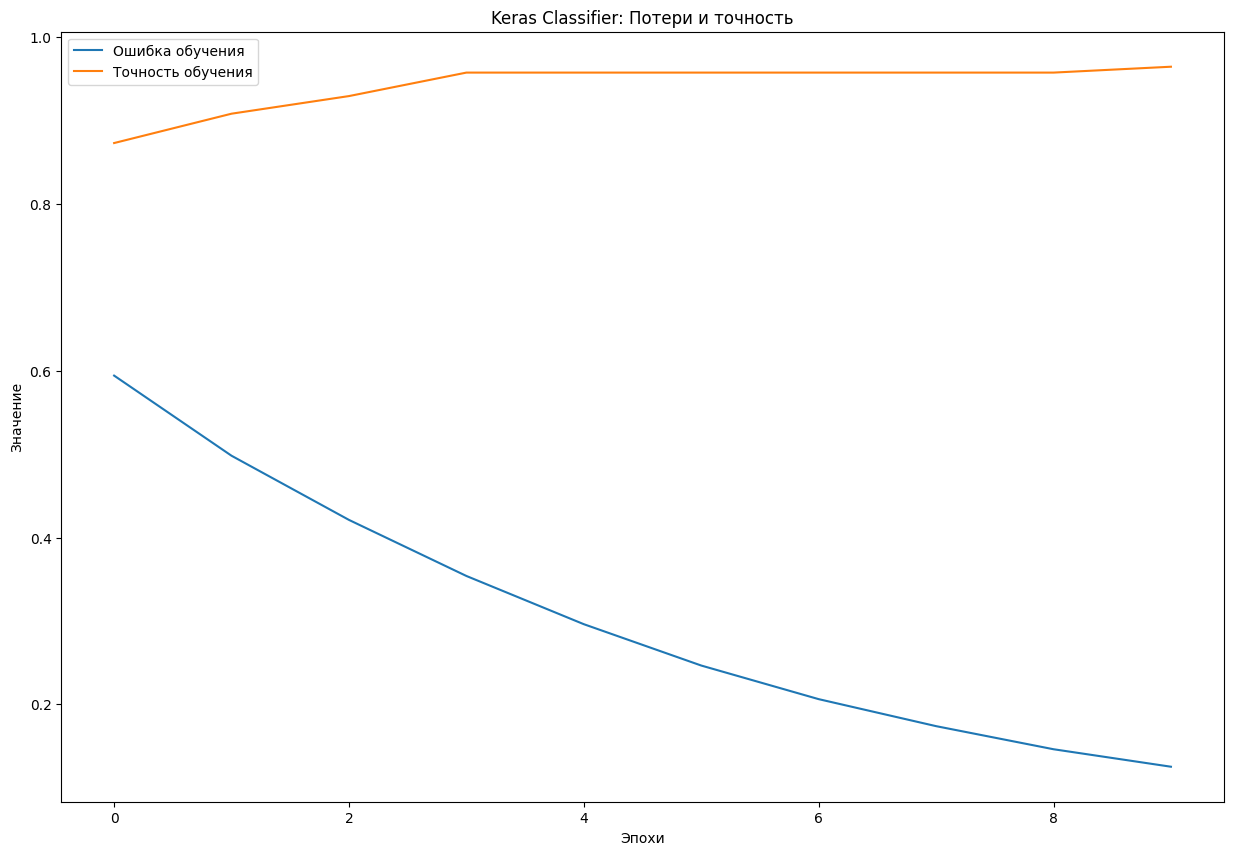

In [97]:
keras_clf_history = class_nn.history.history
plt.figure(figsize=(15, 10))
plt.plot(keras_clf_history['loss'], label='Ошибка обучения')
plt.plot(keras_clf_history['accuracy'], label='Точность обучения')
plt.title('Keras Classifier: Потери и точность')
plt.xlabel('Эпохи')
plt.ylabel('Значение')
plt.legend()

In [90]:
reg_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)